[용어 정리]
#### 전용면적 feature
- 같은 단지코드에 같은 전용면적이라면 동일한 값을 가진다.(<U>전용면적별 세대수는 예외</U>)
- 공급유형, 전용면적, 전용면적별 세대수, 자격유형, 임대보증금, 임대료   
- *같은 단지내 전용면적이 같은 데이터인데 전용면적별세대수 값이 다른 데이터들이 있다. 이것을 한번에 합쳐주면 좋겠다...! 나중에 하자 → 0722_임대보증금임대료_EDA_dmp.ipynb 파일에 초안있음*


#### 단지코드 feature 
- 같은 단지코드라면 동일한 값을 가지는 feature)
- '총세대수', '임대건물구분', '지역', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수', '등록차량수'


## 목표
전용면적 feature을 가지고 전용면적별 임대보증금과 임대료를 예측한 모델을 만들고 싶다.  
단지코드 feature 중에서도 임대보증금과 임대료에 영향을 줄만한 피처들이 있다. 예를 들어 지역이나 임대건물구분 등. 이 피처에 따라 임대보증금과 임대료가 어떻게 차이나는지 확인하고 만약 구분될만한 결과가 보이면 해당 피처를 임대보증금과 임대료를 예측하는 모델을 학습하는데 사용하려고 한다.

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rc, rcParams

warnings.filterwarnings('ignore')
rc('font', family='AppleGothic')
rcParams['axes.unicode_minus']= False

In [2]:
path = './data/'

train = pd.read_csv(path+"train_preprocessed.csv")
train_errx = pd.read_csv(path+"train_errx_preprocessed.csv")
test = pd.read_csv(path+"test_preprocessed.csv")
sub = pd.read_csv(path + 'sample_submission.csv')

train.shape, train_errx.shape, test.shape

((2952, 62), (2896, 62), (1008, 61))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 62 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   단지코드       2952 non-null   object 
 1   총세대수       2952 non-null   int64  
 2   임대건물구분     2952 non-null   object 
 3   지역         2952 non-null   object 
 4   공급유형       2952 non-null   object 
 5   전용면적       2952 non-null   float64
 6   전용면적별세대수   2952 non-null   int64  
 7   공가수        2952 non-null   float64
 8   자격유형       2952 non-null   object 
 9   임대보증금      2371 non-null   float64
 10  임대료        2362 non-null   float64
 11  지하철        2741 non-null   float64
 12  버스정류장      2952 non-null   float64
 13  단지내주차면수    2952 non-null   float64
 14  임대건물구분_lb  2952 non-null   int64  
 15  상가         2952 non-null   float64
 16  아파트        2952 non-null   float64
 17  지역_lb      2952 non-null   int64  
 18  강원도        2952 non-null   float64
 19  경기도        2952 non-null   float64
 20  경상남도    

In [4]:
# 공급유형이 전용면적별로 다른지 확인
codes = train['단지코드'].unique()

for code in codes :
    grp = train.groupby('단지코드')
    grp_dat = grp.get_group((code))
    num = len(grp_dat['공급유형'].unique())
    if num != 1 :
        print(code, num, grp_dat['공급유형'].unique() )

# 결과 : 공급유형은 전용면적별로 다르다

C1925 2 ['영구임대' '임대상가']
C1874 2 ['영구임대' '임대상가']
C2416 2 ['영구임대' '임대상가']
C2621 2 ['영구임대' '임대상가']
C1616 2 ['영구임대' '임대상가']
C1704 2 ['영구임대' '임대상가']
C2258 2 ['영구임대' '임대상가']
C2038 2 ['영구임대' '임대상가']
C1859 2 ['영구임대' '임대상가']
C1722 3 ['공공임대(50년)' '영구임대' '임대상가']
C2190 2 ['영구임대' '임대상가']
C1476 2 ['영구임대' '임대상가']
C1983 3 ['공공임대(50년)' '영구임대' '임대상가']
C2135 2 ['영구임대' '임대상가']
C2034 2 ['영구임대' '임대상가']
C1109 2 ['영구임대' '임대상가']
C2289 2 ['영구임대' '임대상가']
C2597 2 ['영구임대' '임대상가']
C2310 2 ['영구임대' '임대상가']
C2132 2 ['영구임대' '임대상가']
C1439 2 ['영구임대' '임대상가']
C1899 2 ['영구임대' '임대상가']
C1056 2 ['영구임대' '임대상가']
C2644 3 ['공공임대(50년)' '영구임대' '임대상가']
C1206 2 ['영구임대' '임대상가']
C1775 2 ['영구임대' '임대상가']
C1790 2 ['영구임대' '임대상가']
C2109 2 ['영구임대' '임대상가']
C1698 2 ['영구임대' '임대상가']
C1004 2 ['영구임대' '임대상가']
C1875 2 ['영구임대' '임대상가']
C2212 2 ['영구임대' '임대상가']
C2571 2 ['영구임대' '임대상가']
C1344 2 ['공공임대(10년)' '공공임대(분납)']
N2085 3 ['장기전세' '공공임대(10년)' '공공임대(분납)']
C2255 2 ['국민임대' '영구임대']
C2352 2 ['국민임대' '영구임대']
C1039 3 ['장기전세' '국민임대' '영구임대']
C2659 2 ['국민임대' '영구임

## PART I. 임대보증금, 임대료 결측치를 예측하는데 어떤 피처를 사용할 것인가
- 임대보증금과 임대료가 어떤 feature와 상관관계가 있는지 파악해보자
- 주의! 라벨인코딩 되어 있는 *_lb 피처의 값이 높을수록 더 임대보증금과 임대료가 높을만한 피처는 아니다. 그냥 카테고리 숫자일 뿐이다. 모델에 입력할 때는 원핫인코딩으로 라벨링된 피처를 사용한다

### 결과 
'지역_lb', '총세대수', '버스정류장수', '단지내주차면수', '전용면적', '공급유형_lb'

### train 과 test 데이터 세트 합치기

In [5]:
print(train.shape, test.shape)

all_df = pd.concat([train, test])
all_df.reset_index(drop=True, inplace=True)
print(all_df.shape)
all_df.tail()

(2952, 62) (1008, 61)
(3960, 62)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,G,H,I,J,K,L,M,N,O,등록차량수
3955,C1267,675,아파트,경상남도,행복주택,36.77,126,38.0,L,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
3956,C2189,382,아파트,전라북도,국민임대,29.19,96,45.0,H,6872000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3957,C2189,382,아파트,전라북도,국민임대,29.19,20,45.0,H,6872000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3958,C2189,382,아파트,전라북도,국민임대,39.45,202,45.0,H,13410000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3959,C2189,382,아파트,전라북도,국민임대,46.23,60,45.0,H,18689000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


- `임대보증금`와 `임대료`의 전체 데이터 대비 결측치 비율 : 약 19% → 임대보증금, 임대료 예측을 위한 train, test 셋의 비율이 대략 4:1
- `지하철`의 전체 데이터 대비 결측치 비율 : 약 6% 
- `등록차량수`의 전체 데이터 대비 결측치 비율 : 약 25% → 임대보증금, 임대료 예측을 위한 피처에서 제외

In [6]:
all_df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,-1]].isnull().sum() 

단지코드           0
총세대수           0
임대건물구분         0
지역             0
공급유형           0
전용면적           0
전용면적별세대수       0
공가수            0
자격유형           0
임대보증금        767
임대료          776
지하철          249
버스정류장          0
단지내주차면수        0
등록차량수       1008
dtype: int64

> 임대보증금의 결측치보다 임대료의 결측치가 더 많고(임대보증금은 값이 있는데 임대료 값은 없는 경우),  
임대료의 결측치만 제거한 데이터프레임과 임대료 및 임대보증금의 결측치 모두 제거한 데이터 프레임이 같다.

### 1. 임대보증금과 임대료 결측치를 제거한 데이터프레임 만들기

- `notnull_df1` : 임대보증금 결측치 제거한 df
- `notnull_df2` : 임대료 결측치 제거한 df 
- `notnull_df` : 임대보증금,임대료 결측치 제거한 df 

In [7]:
notnull_df1 = all_df[all_df['임대보증금'].notnull()] 
notnull_df2 = all_df[all_df['임대료'].notnull()] 
notnull_df = all_df[all_df['임대보증금'].notnull()&(all_df['임대료'].notnull())] 

print(notnull_df1.shape, notnull_df2.shape, notnull_df.shape)
print(set(notnull_df2) == set(notnull_df))

(3193, 62) (3184, 62) (3184, 62)
True


### 2. <U>지역</U>에 따른 임대보증금과 임대료
- 지역에 따라 임대보증금과 임대료 차이가 보이면 이를 모델에 입력할 피처로 선택할 수 있다.

#### 결과

- 지역이 임대료나 임대보증금에 관계가 있을 것으로 예상했는데, boxplot에서 특정 지역(서울특별시)에서만 높을 뿐 다른 지역은 비슷해보인다. 서울특별시 피처는 사용할만한 것 같다. 그래도 모든 피처를 학습 피처로 사용하는 것이 나을 것 같긴하다.    
- 지역_lb 값이 높을수록 임대료나 임대보증금이 높은 것은 아니니깐 모델 학습시 원핫인코딩된 feature을 사용해야한다.

(3193, 2)
{0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도', 4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시', 8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '전라남도', 12: '전라북도', 13: '제주특별자치도', 14: '충청남도', 15: '충청북도'}


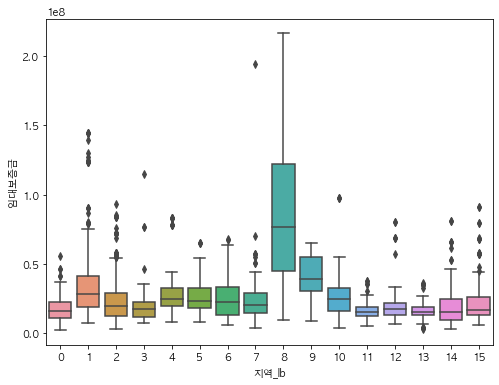

In [8]:
# 지역에 따른 임대보증금 boxplot
var = '지역_lb'
data = pd.concat([notnull_df1['임대보증금'], notnull_df1[var]], axis=1)
print(data.shape)

lb_dict = {0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도', 4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시', 8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '전라남도', 12: '전라북도', 13: '제주특별자치도', 14: '충청남도', 15: '충청북도'}
print(lb_dict)

data.head()
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="임대보증금", data=data)


(3184, 2)
{0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도', 4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시', 8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '전라남도', 12: '전라북도', 13: '제주특별자치도', 14: '충청남도', 15: '충청북도'}


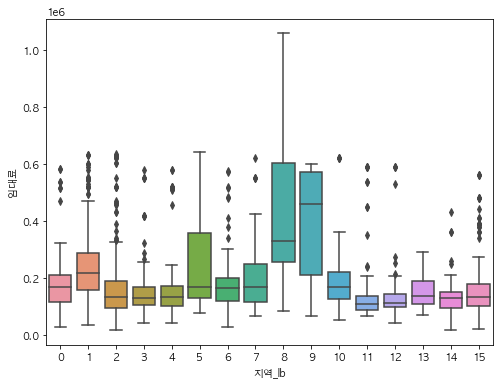

In [9]:
# 지역에 따른 임대료 boxplot
var = '지역_lb'
data = pd.concat([notnull_df2['임대료'], notnull_df2[var]], axis=1)
print(data.shape)

lb_dict = {0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도', 4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시', 8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '전라남도', 12: '전라북도', 13: '제주특별자치도', 14: '충청남도', 15: '충청북도'}
print(lb_dict)

data.head()
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="임대료", data=data)

In [10]:
tmp_df = notnull_df[['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', 
            '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
            '임대보증금','임대료']]
tmp_df.corr()[['임대보증금','임대료']]


,임대보증금,임대료
강원도,-0.123667,-0.029581
경기도,0.218347,0.178686
경상남도,-0.045173,-0.078208
경상북도,-0.089877,-0.079536
광주광역시,0.016294,-0.071532
대구광역시,0.003808,0.087193
대전광역시,-0.026855,-0.029542
부산광역시,-0.027311,0.008267
서울특별시,0.325365,0.257040
세종특별자치시,0.106306,0.241926


### 3. <U>임대건물구분</U>에 따른 임대보증금, 임대료
- 임대건물구분에 따라 임대보증금과 임대료 차이가 보이면 이를 모델에 입력할 피처로 선택할 수 있다.

#### 결과
- 임대보증금과 임대료 값이 모두 있는 '상가'(임대건물구분_lb=0) 데이터가 없어서 모델에 입력할 피처로 사용할 수 없다.

<AxesSubplot:xlabel='임대건물구분_lb', ylabel='임대보증금'>

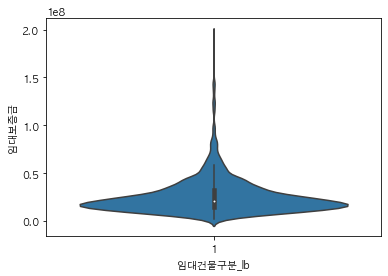

In [11]:
tmp_df = notnull_df[['임대건물구분_lb','임대보증금','임대료']]
sns.violinplot(x='임대건물구분_lb', y='임대보증금', data=tmp_df)
# sns.violinplot(x='임대건물구분_lb', y='임대료', data=tmp_df)

### 4. <U>단지 피처 중 수치형 피처</U>에 따른 임대보증금, 임대료
- 단지 피처 중 수치형 피처 : '총세대수','공가수','지하철', '버스정류장','단지내주차면수'

#### 결과 
- 단지 피처 중에서 특별히 임대보증금과 임대료과 관련있어보이는 피처는 없었다  
- 꼽자면 총세대수, 버스정류장수, 단지내주차면수 정도.. 그런데 그렇게 강한 상관관계는 아니다

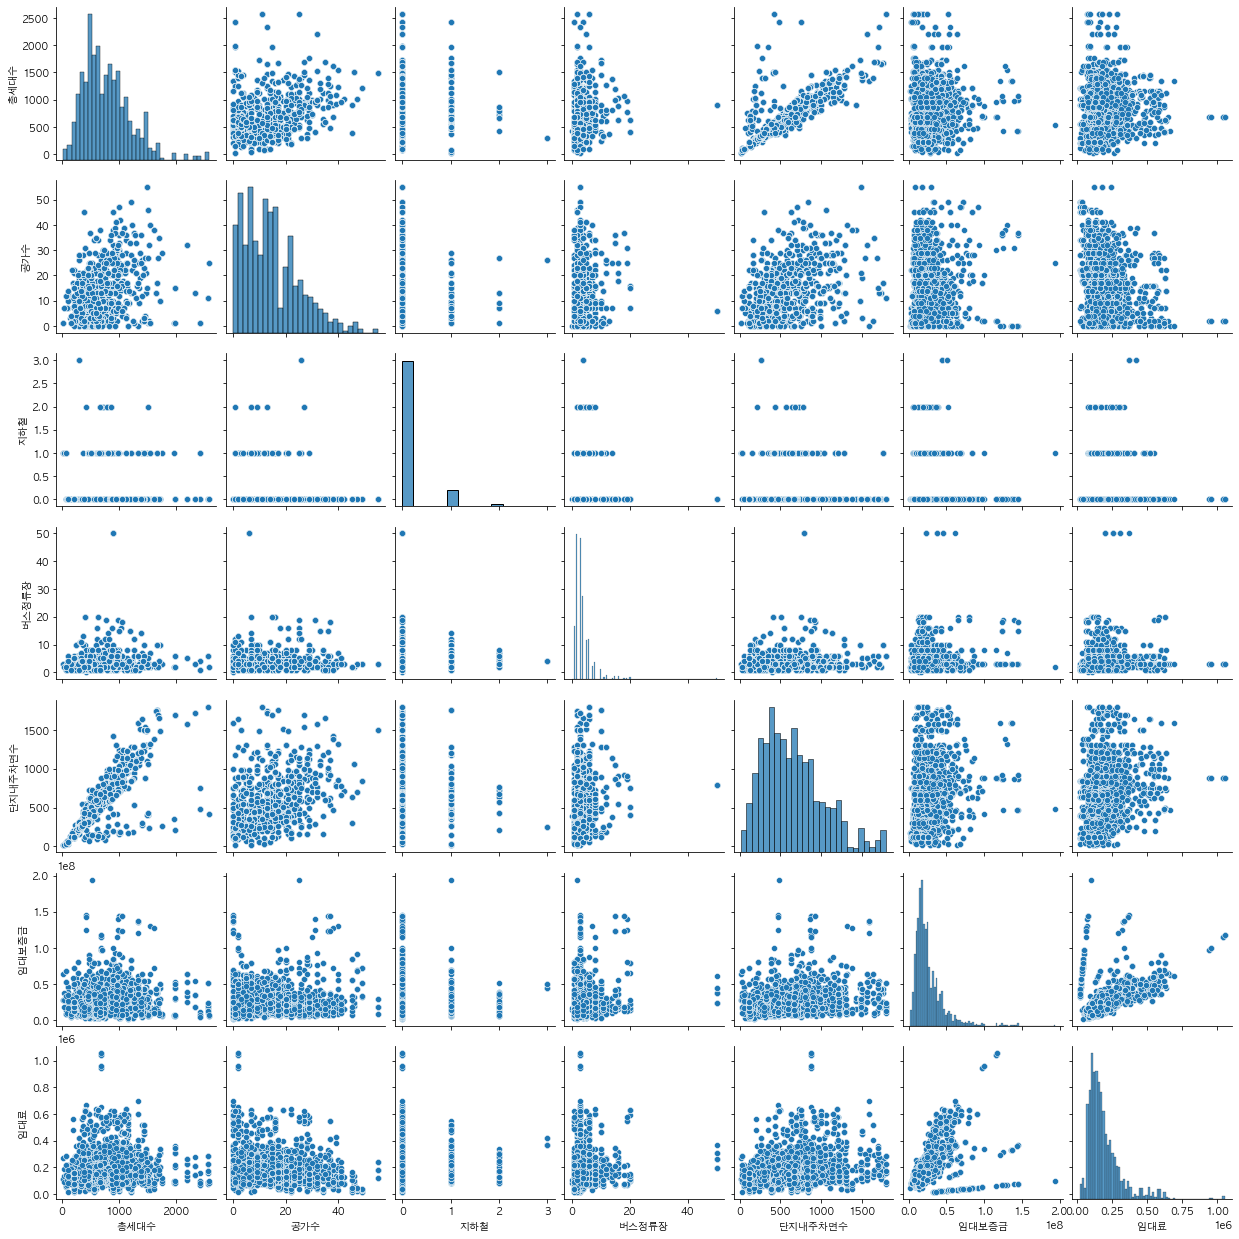

In [12]:
tmp_df = notnull_df[['총세대수','공가수','지하철', '버스정류장','단지내주차면수',
                     '임대보증금','임대료']]
sns.pairplot(tmp_df)

In [13]:
tmp_df.corr()[['임대보증금','임대료']]

,임대보증금,임대료
총세대수,0.118987,0.122154
공가수,0.070809,-0.176815
지하철,0.037633,0.067668
버스정류장,0.120268,0.062063
단지내주차면수,0.258309,0.293565
임대보증금,1.000000,0.530291
임대료,0.530291,1.000000


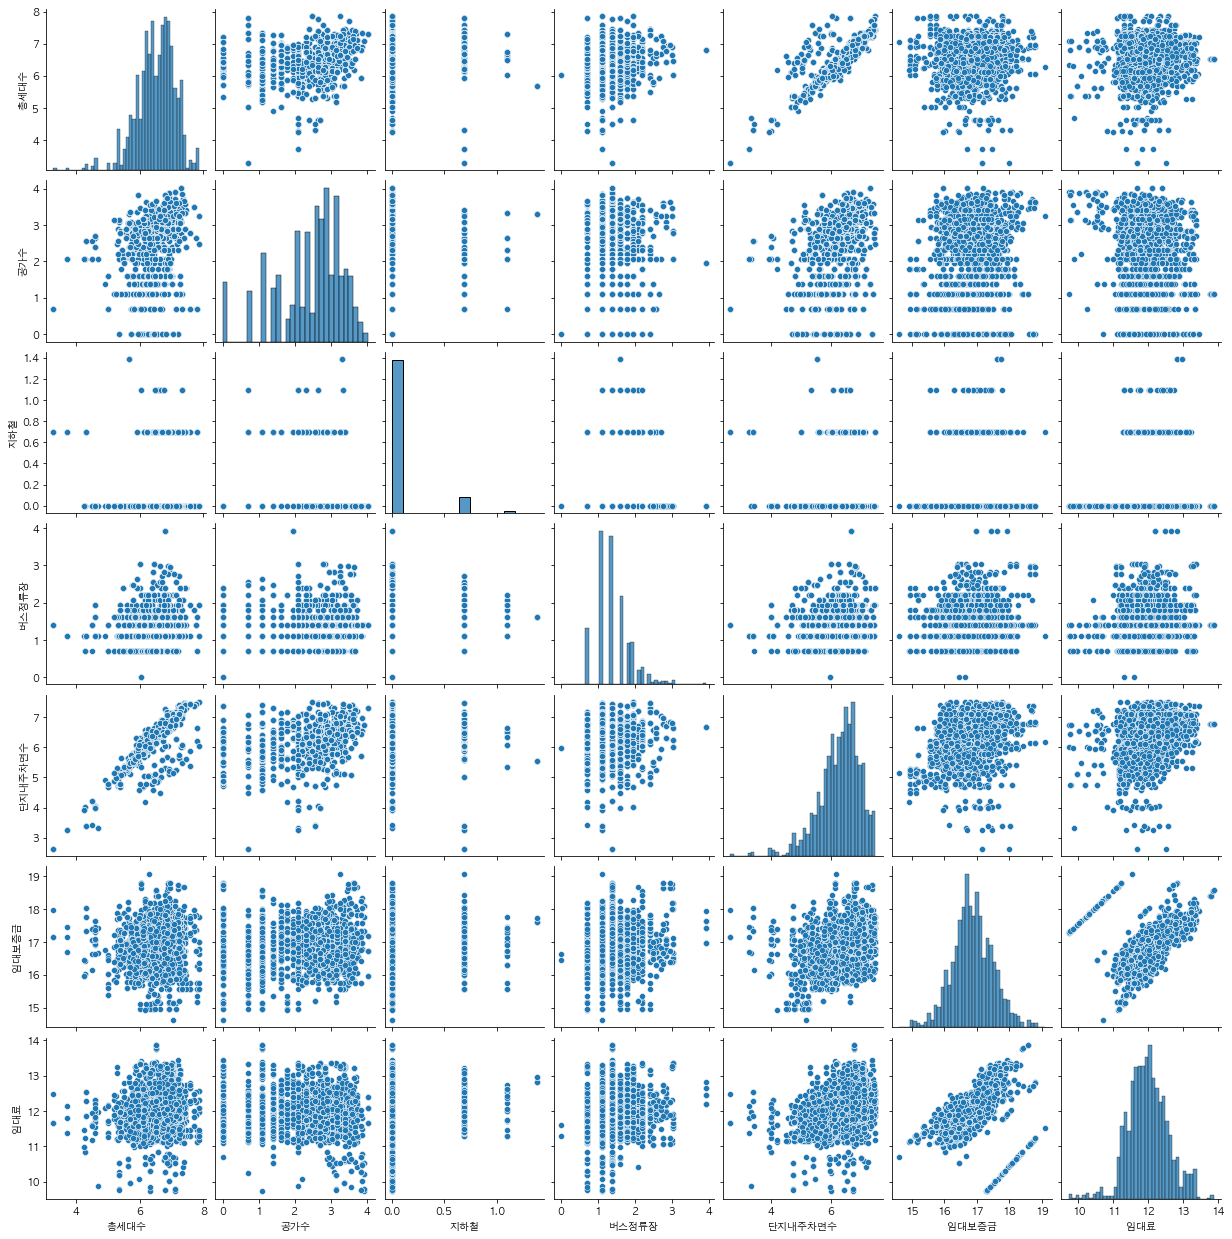

In [14]:
# log를 취하면 어떻게 될까? 더 나아질까?
tmp_10 = np.log1p(tmp_df)
sns.pairplot(tmp_10)


In [15]:
tmp_10.corr()[['임대보증금','임대료']]

,임대보증금,임대료
총세대수,0.101101,0.167305
공가수,0.092666,-0.158924
지하철,0.062466,0.112131
버스정류장,0.123777,0.124504
단지내주차면수,0.304961,0.318278
임대보증금,1.000000,0.515126
임대료,0.515126,1.000000


> 더 나아지는 것으로 보이진 않는다.. log 취하지 않기
### 4. <U>전용면적, 전용면적별세대수</U>에 따른 임대보증금, 임대료

#### 결과
- '전용면적'은 임대보증금과 임대료를 예측하는데 좋은 피처가 될 것 같다.
- '전용면적별 세대수'는 사용하지 않는 것이 좋을 것 같다.

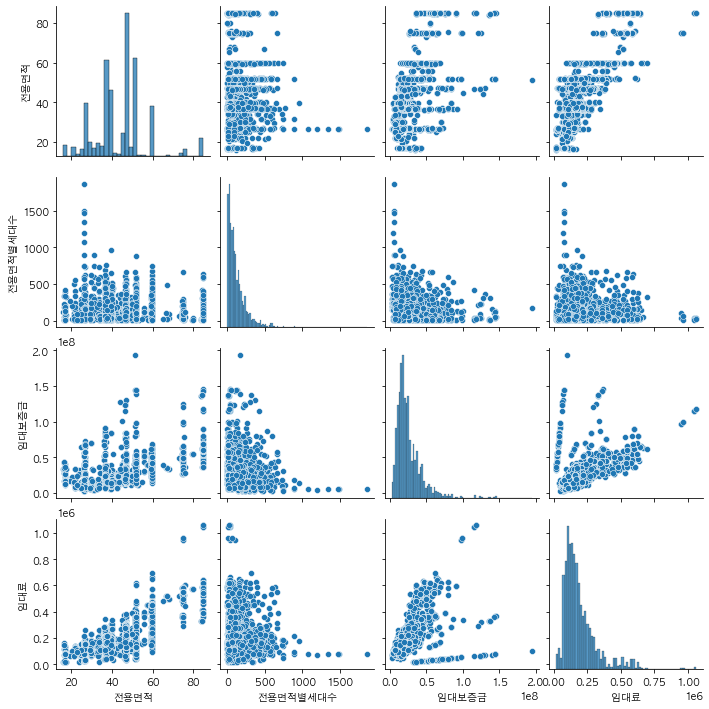

In [16]:
tmp_df = notnull_df[['전용면적', '전용면적별세대수',
                     '임대보증금','임대료']]
sns.pairplot(tmp_df)


In [17]:
tmp_df.corr()[['임대보증금','임대료']]

,임대보증금,임대료
전용면적,0.520476,0.734829
전용면적별세대수,-0.093588,-0.039620
임대보증금,1.000000,0.530291
임대료,0.530291,1.000000


### 5. <U>전용면적 피처 중 범주형 피처</U>에 따른 임대보증금,임대료의 상관관계
#### 결과
- `공급유형_lb`이 괜찮은 피처가 될 수 있을 것 같다.
- `자격유형_lb`은 애매하다.

<AxesSubplot:xlabel='자격유형_lb', ylabel='임대료'>

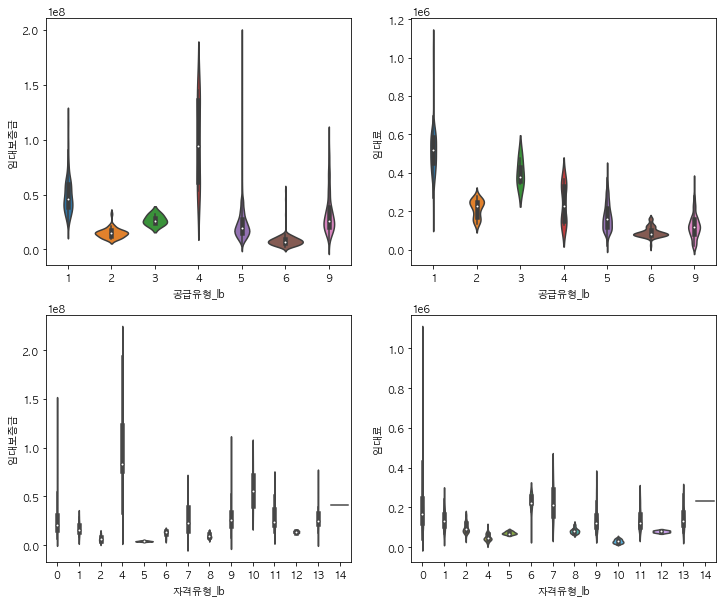

In [18]:
tmp_df = notnull_df[['공급유형_lb','자격유형_lb','임대보증금','임대료']]


plt.figure(figsize=(12,10))

plt.subplot(221)
sns.violinplot(x='공급유형_lb', y='임대보증금', data=tmp_df)
plt.subplot(222)
sns.violinplot(x='공급유형_lb', y='임대료', data=tmp_df)

plt.subplot(223)
sns.violinplot(x='자격유형_lb', y='임대보증금', data=tmp_df)
plt.subplot(224)
sns.violinplot(x='자격유형_lb', y='임대료', data=tmp_df)



### 결론
'지역_lb', '총세대수', '버스정류장수', '단지내주차면수', '전용면적', '공급유형_lb' (+'자격유형_lb') 를 꼽을 수 있을 것 같다.  
*이를 앞으로 my_features로 부르자.*

## PART II. 모델 선택에 대한 검증
- 사용 가능한 모델
    - LinearRegression
    - Ridge, Lasso
    - RandomForestRegressor
    - DecisionTreeRegressor
    - GradientBoostingRegressor
    - XGBRegressor
    - LGBMRgresor
    
### 1.LinearRegression
- 선형 알고리즘 사용할 수 있는가는 __다변량 분석__을 통해서 확인해볼 수 있다. 
- 더 공부해야봐야알겠지만... 데이터의 정규성, 등분산성, 선형성, 잔차의 상관성을 만족하는지 확인해본다.
- 
> 각 변수들의 분포가 약간의 skewness가 있어서 log를 취해봣는데 더 안좋아졌다..ㅎ  
skewness를 수치적으로 확인하는 방법을 알면 좋을 것 같다. 효진님이 분석하신 [캐글노트북](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)  
- *공부해야할 것 : 다변량 분석, skewness 수치화*

### 결과
LinearRegression은 내가 고른 피처에 그렇게 좋은 모델이 아닌 것 같다.

array([[<AxesSubplot:title={'center':'총세대수'}>,
        <AxesSubplot:title={'center':'버스정류장'}>],
       [<AxesSubplot:title={'center':'단지내주차면수'}>,
        <AxesSubplot:title={'center':'전용면적'}>],
       [<AxesSubplot:title={'center':'임대보증금'}>,
        <AxesSubplot:title={'center':'임대료'}>]], dtype=object)

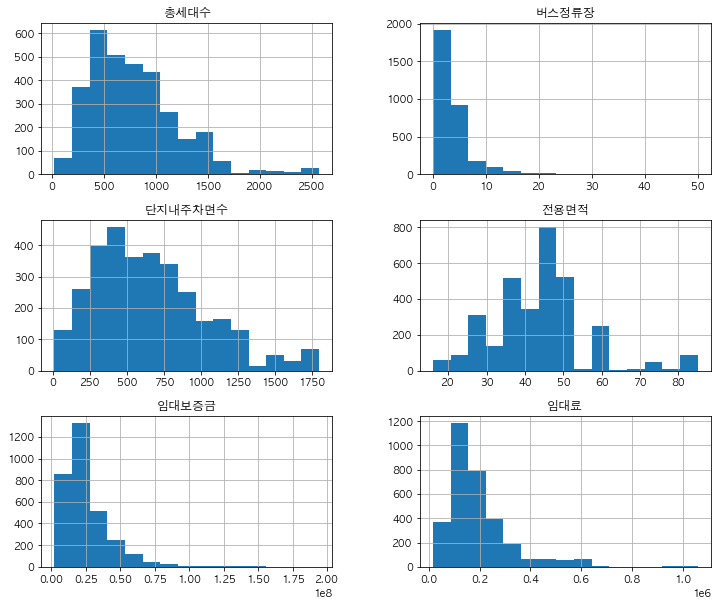

In [22]:
# my_feature 중에 수치형 피처 (범주형 피처는 값의 대소가 의미가 없기 때문에 제외한다)
tmp = notnull_df[['총세대수', '버스정류장', '단지내주차면수', '전용면적','임대보증금','임대료']]
tmp.hist(figsize=(12,10), bins=15)

array([[<AxesSubplot:title={'center':'총세대수'}>,
        <AxesSubplot:title={'center':'버스정류장'}>],
       [<AxesSubplot:title={'center':'단지내주차면수'}>,
        <AxesSubplot:title={'center':'전용면적'}>],
       [<AxesSubplot:title={'center':'임대보증금'}>,
        <AxesSubplot:title={'center':'임대료'}>]], dtype=object)

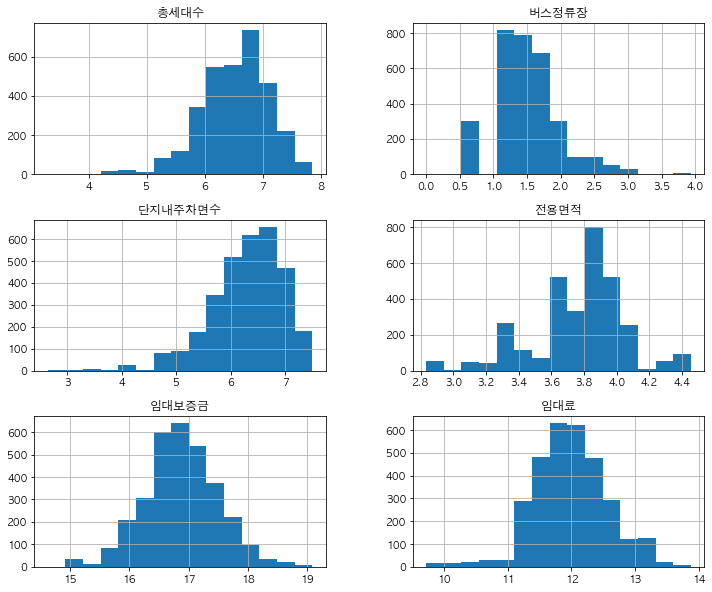

In [23]:
tmp_log = np.log1p(tmp)
tmp_log.hist(figsize=(12,10), bins=15)

(2952, 10) (2952, 10)
(5904, 10)


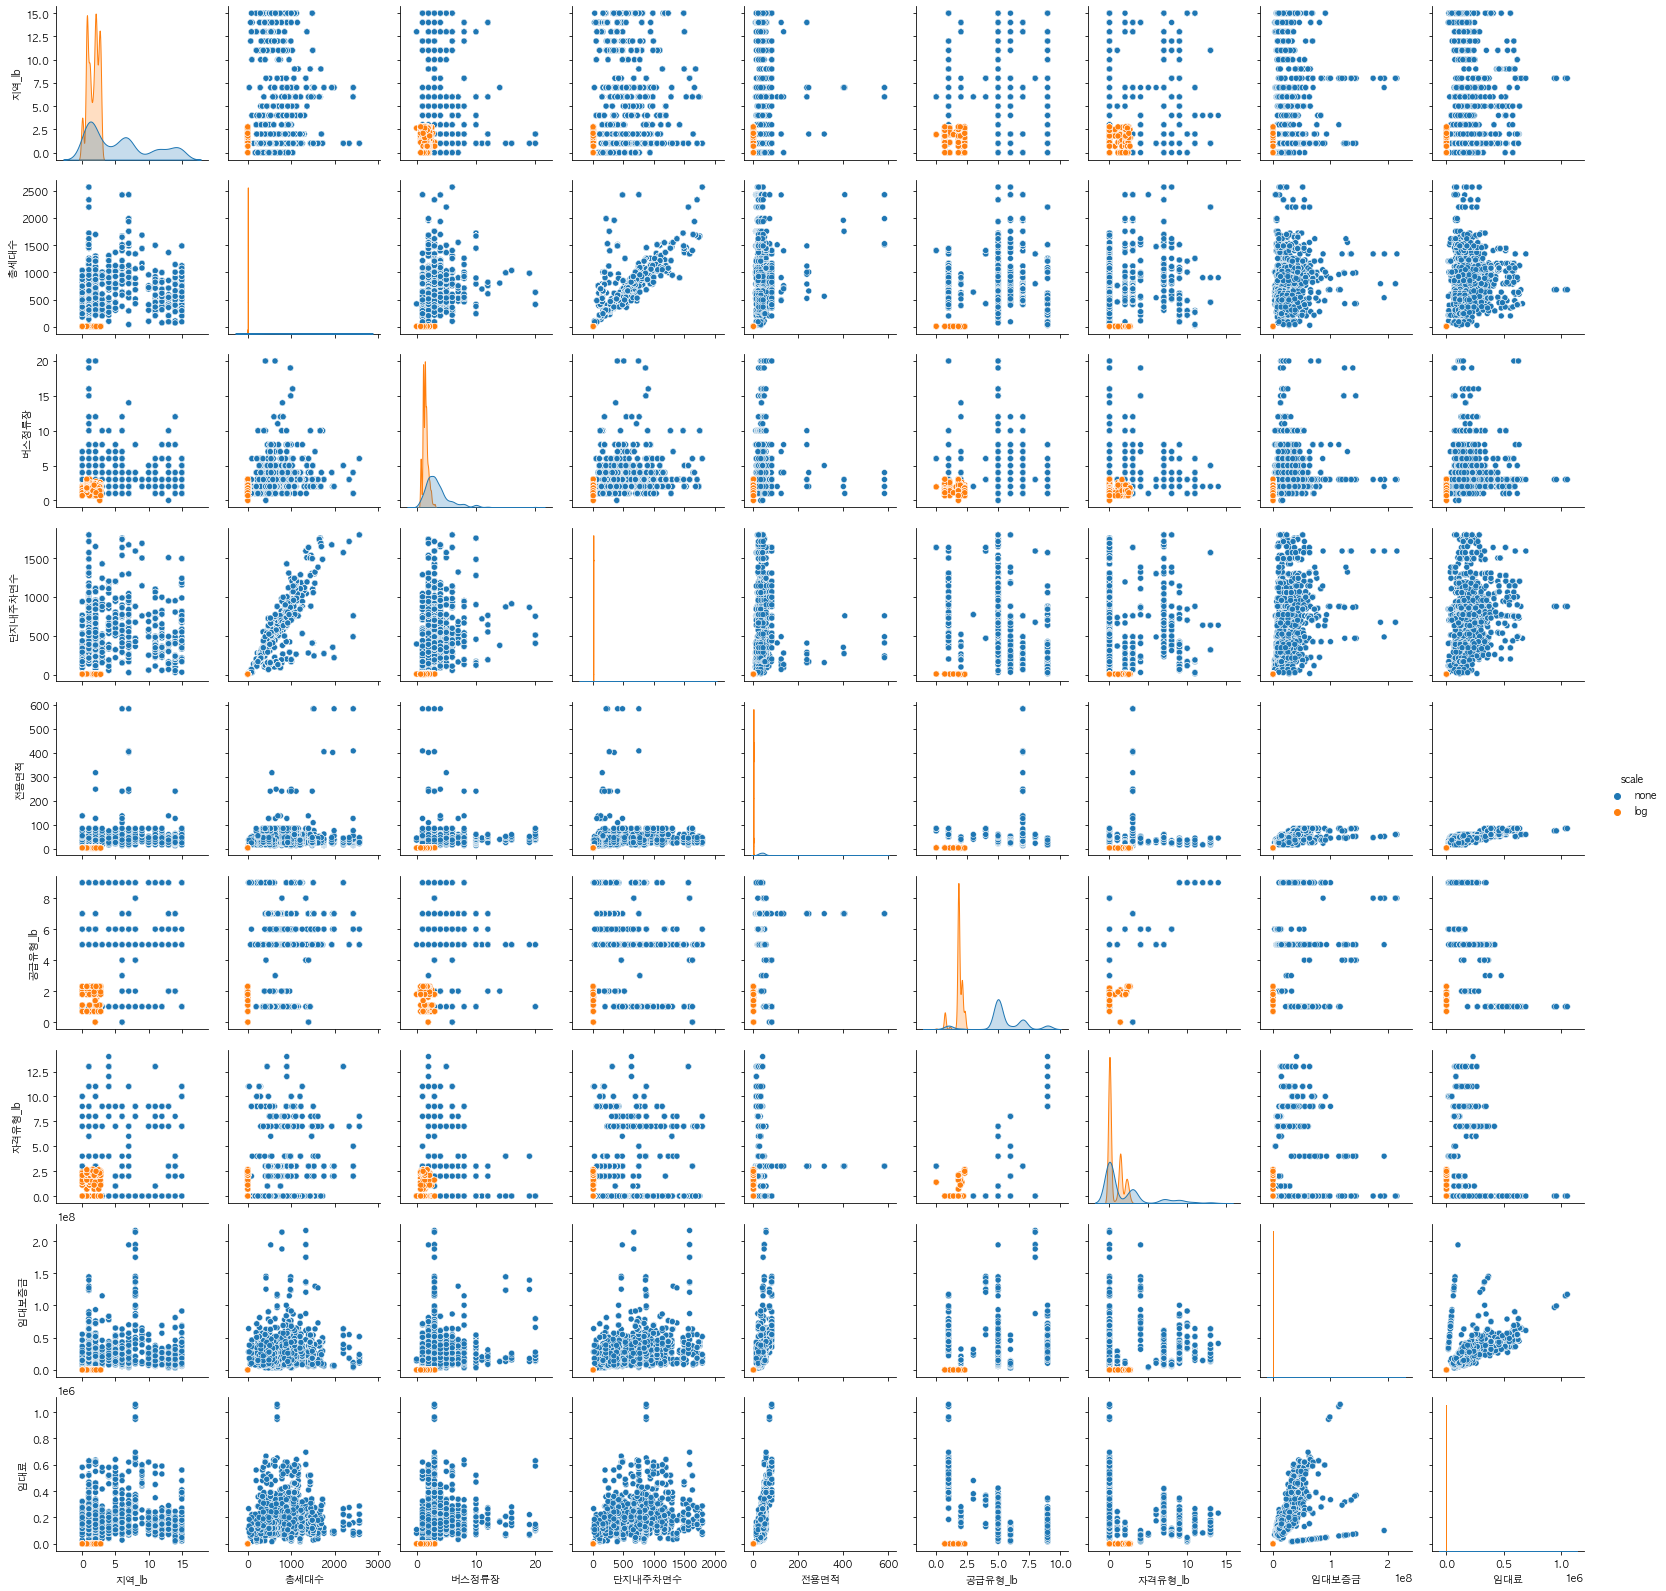

In [21]:
tmp = notnull_df[['지역_lb', '총세대수', '버스정류장', '단지내주차면수', '전용면적', '공급유형_lb','자격유형_lb','임대보증금','임대료']]
tmp_log = np.log1p(tmp)

tmp['scale'] = 'none'
tmp_log['scale'] = 'log'
print(tmp.shape, tmp_log.shape)

tmp_all = pd.concat([tmp, tmp_log])
print(tmp_all.shape)

# cols = tmp_all.columns
# for i, col in enumerate(cols):
#     sns.displot(tmp_all, x=col, hue="scale")

sns.pairplot(tmp_all, hue='scale')


> EDA 완료